# Activity 3: SPDC Simulation by QuTip

Quantum optics relies on a reliable source of single photons and entangled photon pairs.  A typical source of these photons is spontaneous parametric down-conversion (SPDC) within a nonlinear crystal.  For example, all of the quantum optics experimental lab modules in this class rely on SPDC.   

In this activity, we will simulate the SPDC process and the squeezed light it generates.  We will do this through the formalism of the degenerate parametric amplifier.  

Specific aims of this activity are:

 * Enrich your understanding of the SPDC process.
 * Develop a realistic model of an SPDC source that could be further extended and used in the context of device and technology simulation and design.

## Imports and Headers

Install qutip if needed and import tools for the simulations performed throughout this activity.

In [ ]:
#Install qutip
!pip install qutip

#Import qutip functions
from qutip import *

#Matplotlib tools for plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

#Numpy for numerics
import numpy as np
from numpy import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 57.1 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


(content-t1-3-E2-spdc)=
### Operators and Hamiltonian

If you have not read it yet, please read the introduction to how SPDC is physically generated in the [text](content-t2e1-intro-single-photons) for the T2E1 lab module.

The SPDC process works by driving a nonlinear crystal with strong light at a pump frequency $\omega_p$.  One photon of the pump light is then spontaneously converted into two photons $\omega_s$ and $\omega_i$, which refer to the signal and idler modes respectively.  This naming convention was developed to describe parametric amplfiers where one wanted to amplify a weak signal using a strong pump.  Energy conservation requires that this also corresponds with the growth of an idler wave, and you have that $\omega_p = \omega_s + \omega_i$.  In the SPDC process we are concerned with the spontaneous generation of the signal and idler.  These occupy modes as $a$ and $b$ respectively.  

The parametric amplification occurs due to a nonlinear coupling between the fields of the pump, signal, and idler waves.  The coefficient describing the strength of this coupling is the nonlinear coefficient $\chi_2$, which is in general complex, but given freedom in choice of phase, we take it as a positive real number here.

The coupling Hamiltonian for the SPDC process can be represented as

$$
\hat{H} = i\hbar(\chi_2 \hat{p}^\dagger \hat{a} \hat{b} - \chi_2 \hat{p} \hat{a}^\dagger \hat{b}^\dagger)\mbox{,}
$$

where $p$ represents the pump mode.  The right part describes the loss of one pump photon resulting in the increase of one photon in modes $a$ and $b$ (the signal and idler).  The left part represents back conversion from signal and idler to a pump photon.

Given a strong coherent state pump, we can represent its operator with a complex number $\alpha_p$ corresponding to its amplitude.  Doing this  we have the Hamiltonian we want to solve for this exercise as

$$
\begin{aligned}
\hat{H}_{ab} = i \hbar \frac{\chi}{2} (\hat{a} \hat{b} - \hat{a}^{\dagger} \hat{b}^{\dagger})
\end{aligned}
$$

where we define

$$
\chi \equiv 2 \chi_2 |\alpha_p|.
$$

Note that we use the liberty of setting the pump phase arbitrarily, and define it by the amplitude $|\alpha_p|$.  

## Prelab Exercises

 0a. Show that $\frac{d\hat{a}}{dt} = -\frac{\chi}{2}\hat{b}^{\dagger}$, and  $\frac{d\hat{b}^{\dagger}}{dt} = \frac{\chi}{2}\hat{a}$. (Hint: use the fact that $\frac{d\hat{a}}{dt} = \frac{i}{\hbar}[\hat{H}, \hat{a}]$ for any operator $\hat{a}$).

 0b.  The above coupled differential equation has the solutions $\hat{a}(T) = \cosh (\chi T/2) \hat{a}(0) - \sinh(\chi T/2) \hat{b}^\dagger (0)$ and $\hat{b}^\dagger(T) = -\sinh (\chi T/2) \hat{a}(0) + \cosh(\chi T/2) \hat{b}^\dagger (0)$ at time $T$ given the initial operators at time $0$. Derive the output photon number in $a$ and $b$ at a time $T$.  (Hints: Start with the vacuum state and apply the number operator; you should get something with $\sinh^2$).  

## Simulate Time-Dependent Problem in QuTiP

In the following code we define the needed creation and annihilation operators as well as the Hamiltonian of the system to solve.  The `tensor()` function is used to create composite operators that act on the joint Hilbert space of the two modes $a$ and $b$. The `destroy()` and `num()` functions create the annihilation and number operators, respectively.

Note that a difference between the following code and the equations above is that we factor out the $\hbar$ term from the Hamiltonian.  By default, the unit of time in Qutip is set to be dimensionless, so $\hbar$ is used to convert between dimensionless time and physical time.  In other words, the units in QuTiP are such that $\hbar = 1$.  

For the coupling term $\chi$ we have selected a value that, in combination with the phase-matching bandwidth (provided below), results in a photon generation rate similar to what you see in the lab experiments. This will be described further in Exercise 1 where you calculate the photon pair generation rate.

In [ ]:
#Constants
hbar=6.67e-34/(2*pi) #Planck's reduced constant
eps0=8.85e-12 # permittivity of free space
c=2.99792458e8 # speed of light

#User Parameters
phase_matching_bandwidth=1e13 # approximate in Hz (you can make this consisten with experimental measurement)
chi=1e-6 #Defines strength of nonlinearity, driven by peak pump field strength and chi2
N1 = 10 #Number of photon orders in Fock state basis for a
N2 = 10 #Number of photon orders in Fock state basis for b

#presentation parameters
plot_fontsize=12

# definitions of operators
# -- we define the operators through tensor products...
# -- two quantum objects per tensor product as we have
# -- two modes we are simulating here, a and b
a  = tensor(destroy(N1), qeye(N2))
na = tensor(num(N1),     qeye(N2))
b  = tensor(qeye(N1),    destroy(N2))
nb = tensor(qeye(N1),    num(N2))

#Now we define the coupling Hamiltonian as in the text above:
H0 = 0*a # interaction Hamiltonian before the 3-wave mixing (used for calculating initial state)
Hab =  1j*chi * (a * b - a.dag() * b.dag())/2

## Initial state and state evolution

In the following, we initialize/define:
* input state $\ket{\psi_0}$ of modes a and b, which are both in the vacuum state
* `tlist`: a list of times that specifies the times at which the system should be evaluated during the evolution. In the example, tlist is created using the numpy function linspace, which generates an array of evenly spaced values over a specified interval.
* `c_ops`: a list of collapse operators that describe the sources of decoherence and dissipation in the system. Collapse operators represent the interactions of the system with its environment that cause transitions between the energy eigenstates of the system.
* `e_ops`: a python list storing observables. Here, the e_ops list is empty, which means that there are no observables being monitored during the evolution of the system.

We then use the function mesolve from the Qutip library to solve the [quantum master equation ](https://https://en.wikipedia.org/wiki/Quantum_master_equation) to find the time evolution of the system. The function takes as input the Hamiltonian `Hab`, the initial state `psi0`, the list of times `tlist`, the list of collapse operators `c_ops`, and the list of observables `e_ops`. The function returns an object output that contains information about the time evolution of the system, such as the states of the system at each time in `tlist`.

In the example, the `c_ops` list is empty, which means that there are no sources of decoherence or dissipation in the system. As a result, the evolution of the system is purely unitary and described by the Hamiltonian $H_{ab}$.

The following code uses a python dictionary data structure to conveniently store operators and expected values. In anticipation of correlation values to be considered below, we're including those in our dictionary as well.  

In [ ]:
# System Definition:

# Initial State
# -- start in the ground (vacuum) state
psi0 = tensor(basis(N1,0), basis(N2,0)) # initial state in the vacuum: |0>|0>

c_ops = [] # c_ops is a list of collapse operators that describe the sources of
            # decoherence and dissipation in the system. Collapse operators represent
            # the interactions of the system with its environment that cause
            # transitions between the energy eigenstates of the system.


tlist = np.linspace(0, 1000, 1000) # tlist is a list of times that specifies the
                                   # times at which the system should be evaluated
                                   # during the evolution. In the example, tlist
                                   # is created using the numpy function linspace,
                                   # which generates an array of evenly spaced
                                   # values over a specified interval.

e_ops = [] # e_ops is a python list storing observables. Here, the e_ops list is
           # empty, which means that there are no observables being monitored
           # during the evolution of the system

# -- Solve Quantum Master Equation --
psi_out = mesolve(Hab, psi0, tlist, c_ops, e_ops)

### Exercise 1

 1a. Verify the Hermiticity of the Hamiltonian.

 1b. Define operator objects for the number operators $\hat{N}$ in $a$ and $b$, as well as the operator for $\hat{N}^2$ for $a$ and $b$.  

 1c. Use the `expect()` function to evaluate the expectation of the photon number in $a$ and $b$ for all of the output states, provided by `phi_out.states`.  You should have `1000` output states, one for each point in time in `tlist`.  Plot the growth of the photon number as a function of time.  Does it makes sense? (Compare directly to your expected expression from the pre-lab).

 1d. Now calculate the standard deviation of the photon number in $a$ and $b$.  Explain the nature of the growth of the standard deviation.  Does it also match expectations?  Explain why this growth behavior make sense?

 1e. The photon rate can be expressed as the phase-matching bandwidth times the photon number which provies the output photons per second.  Given the maximum value at the final time in the interaction, what is the photon emission rate?  How does this compare to the incident pump photon rate assuming a pump wavelength of 400 nm and power of 10 mW?  

The code block below gets you started.  If needed, a refresher on photon number operators and photon number statistics is provided in [BASICS -- Quantum Optics](content-basics-quantum-optics).



In [ ]:
na = a.dag()*a #number operator for mod a
e_na = expect(na, psi_out.states)

#... your code here to finish the exercise ...

## State evolution

Next, we will plot the photon distributions of two quantum optical modes a and b at selected times.

The time indices are spaced over the number of time steps in `tlist`.  

The following subplots show the state evolution (note the plots have shared horizontal and vertical axes). We represent the photon distributions as bar plots on the subplots.

Only single-photon pairs in $a$ and $b$ are generated at a non-neglibile rate (but are still far fewer than the number of incident pump photons), with neglible amounts of higher order Fock state generation.

interactive(children=(IntSlider(value=30, description='t', max=999), Output()), _dom_classes=('widget-interact…

<function __main__.update_plot(t)>

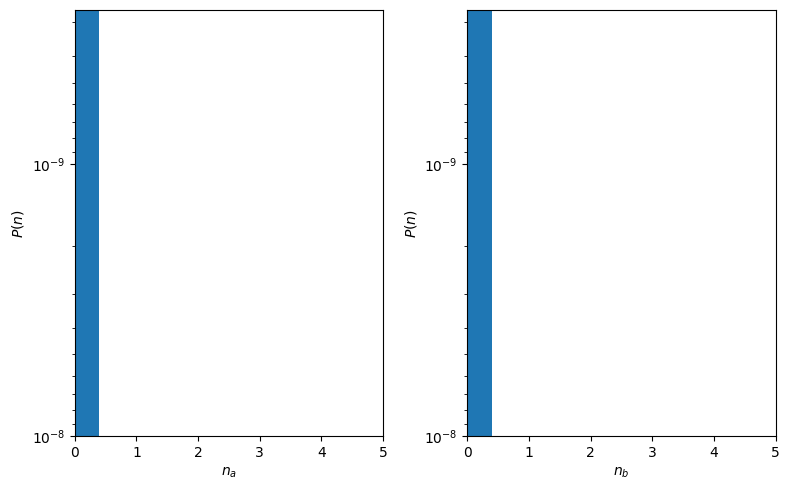

In [ ]:
import ipywidgets as widgets
from IPython.display import display

xmin,xmax = 0,5

def update_plot(t):
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))
    psia = ptrace(psi_out.states[t], 0)
    psib = ptrace(psi_out.states[t], 1)
    bar_vals_a = real(psia.diag())
    bar_vals_b = real(psib.diag())
#    max_val = max(bar_vals_a.max(), bar_vals_b.max())
    max_val = max(bar_vals_a[1:].max(), bar_vals_b[1:].max()) # ignore first entry P(0) which is always gonna be large
    axes[0].bar(range(N1), bar_vals_a)
    axes[1].bar(range(N2), bar_vals_b)
    axes[0].set_ylabel('$P(n)$')
    axes[1].set_ylabel('$P(n)$')
    axes[0].set_xlabel('$n_a$')
    axes[1].set_xlabel('$n_b$')
    axes[0].set_yscale('log')
    axes[1].set_yscale('log')
    axes[0].set_ylim(bottom=10**-8, top=bar_vals_a[1]*1.2)
    axes[1].set_ylim(bottom=10**-8, top=bar_vals_a[1]*1.2)
    axes[1].set_xlim(xmin,xmax)
    axes[0].set_xlim(xmin,xmax)

    fig.tight_layout()

t_selector = widgets.FloatSlider(
    min=0,
    max=floor(len(tlist)/2),
    step=1,
    value=0,
    description='Time index:',
    continuous_update=False
)

#display(t_selector)
widgets.interact(update_plot, t=widgets.IntSlider(min=0, max=len(tlist)-1, step=1, value=30))


### Exercise 2

2a. Increase the coupling term, $\chi$ and redo the above state visualization.  What happens in terms of the photon number distribution when $\chi$ becomes large?  Does the analytical solution still hold?

## Second-order coherence

Here we examine the generated photon statistics further by looking at the second order correlation function of photons in the outgoing modes $a$ and $b$. Note that second order coherence of single and heralded single-photons using SPDC is explored further in the [T2E1 lab](content-t2e1-intro-single-photons) through the use of a HBT measurement.

Classical fields satisfy the Cauchy-Schwarz inequality evaluated at the same time $t$ on both detectors (Walls and Milburn, page 79).  This can be expressed with respect to the second order correlation functions of the output state at time $t$ as:

$$(g^{(2)}_{ab})^2 \leq g^{(2)}_{aa} g^{(2)}_{bb}$$

where

$$g^{(2)}_{ab} = \frac{\langle \hat{a}^\dagger \hat{a} \hat{b}^\dagger \hat{b} \rangle}{\langle \hat{a}^\dagger \hat{a} \rangle \langle \hat{b}^\dagger \hat{b}\rangle} $$

and

$$g^{(2)}_{aa} = \frac{\langle \hat{a}^\dagger \hat{a}^\dagger \hat{a} \hat{a} \rangle}{\langle \hat{a}^\dagger \hat{a} \rangle ^2} $$

and likewise for $g^{(2)}_{bb}$.  

In the following you will explore this inequality further.

### Exercise 3

3a. Using the same procedure as for the photon number expectation calculations, now calculate and plot the second order correlation functions for $g^{(2)}_{aa}$, $g^{(2)}_{bb}$, and $g^{(2)}_{ab}$.  

3b. Is the Cauchy-Schwarz inequality broken?  

3c. You should find that the photon correlations of the squeezed fields produced from a vacuum passing through the parametric amplifier are not just strongly nonclassical but actually saturate the bound on the maximum allowed by quantum mechanics.  Discuss why this makes SPDC a valuable resource from the context of quantum technologies.

## Bonus: Degenerate SPDC and Squeezing

Two-photon states generated by degenerate SPDC sources (*i.e.* SPDC sources where the signal and idler share a single output mode) exhibit squeezing (see [](sec:quantum-optics-basics:squeezed-states)).  In fact, similar processes to what you are modeling are used to generate bright squeezed light that is enabling ultra-precise interferometric measurements.  To see how squeezed states can be used to reduce the readout noise of an interferometer, see [](content-t3e1-extras-homodyne-detection).

**Ba.** Implement a degenerate SPDC where both photons emitted into a single mode. This is decribed by the Hamiltonain

$$\hat{H}_{aa} = i \hbar \frac{\chi}{2} (\hat{a}^2 - \hat{a}^{\dagger2} )$$

Use the same settings as above for the non-degenerate SPDC generation (i.e. same `chi`, `tlist`, etc).

**Bb.** Calculate and visualize the Wigner function of the output state using QuTiP (`qutip.Wigner`).  The Wigner function helps visualize the field distribution of the outgoing state along the in-phase and quadrature planes.  

**Bc.** Now increase the nonlinearity setting `chi=5e-4`.  Plot the Wigner function again.  What is the difference? Do you see the halmarks of squeezing? 

In [ ]:
#Wigner function example you can use:

xvec = np.linspace(-4, 4, 100)
W_out = qutip.wigner(psi_out.states[-1], xvec, xvec)
plt.contourf(xvec, xvec, W_out, 100)
